In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


In [20]:
import os
def get_path():
    Path = os.getcwd() + '\\data\\'
    return Path

In [22]:
import glob 
Path = get_path()
# glob.glob(Path + 'e')
Path

'd:\\python_practice\\DACON\\subscription_classification\\dacon_subscription_classification\\data\\'

In [2]:
dir = 'data/'

train = pd.read_csv(dir+'train.csv')
test = pd.read_csv(dir+'test.csv')
submission = pd.read_csv(dir+'sample_submission.csv')

train.head()

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,b919c29d,13,14,14.946163,8.427187,18,16,68.360455,3,4,Low,Basic,4,5,0
1,a0a60abb,16,18,18.453224,72.646087,16,13,97.567322,2,3,Medium,Basic,1,6,1
2,b9f171ae,22,1,16.195228,21.774492,13,14,94.358763,3,4,Medium,Premium,0,7,1
3,5dc0ba8b,1,19,17.628656,42.659066,19,18,70.153228,0,3,Low,Basic,1,0,1
4,65c83654,4,5,21.390656,30.744287,19,10,81.917908,2,4,Medium,Basic,3,0,1


In [3]:
def set_train_feature_target(train, user_id=str, target=str):
    X = train.drop([user_id, target], axis=1)
    y = train[target]
    return X, y

In [7]:
X, y = set_train_feature_target(train, 'user_id', 'target')
y

0       0
1       1
2       1
3       1
4       1
       ..
9995    1
9996    1
9997    1
9998    1
9999    0
Name: target, Length: 10000, dtype: int64

In [31]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OneHotEncoder

def create_preprocessor(X, numeric_scaler_type='standard'):
    numeric_scalers = {
        'standard': StandardScaler(),
        'minmax': MinMaxScaler(),
        'norm': Normalizer()
        }
    
    numeric_features = X.select_dtypes([np.number]).columns
    categorical_features = X.select_dtypes(exclude=[np.number]).columns
    print(numeric_features)
    numeric_transformer = Pipeline(
        steps=[
        ('NumericScaler', numeric_scalers[numeric_scaler_type])
        ]
    )
    categorical_transformer = Pipeline(
        steps=[
        ('OneHot', OneHotEncoder(sparse_output=False))
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    return preprocessor
from sklearn.ensemble import RandomForestClassifier
def create_pipeline(preprocessor):
    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('rf', RandomForestClassifier())
        ]
    )
    return pipeline

X_train, X_test, y_train, y_test = split_data(X, y)
pre = create_preprocessor(X_train)
pipe = create_pipeline(pre)
pipe.fit(X_train, y_train)

Index(['subscription_duration', 'recent_login_time', 'average_login_time',
       'average_time_per_learning_session', 'monthly_active_learning_days',
       'total_completed_courses', 'recent_learning_achievement',
       'abandoned_learning_sessions', 'community_engagement_level',
       'customer_inquiry_history', 'payment_pattern'],
      dtype='object')


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('NumericScaler',
                                                                   StandardScaler())]),
                                                  Index(['subscription_duration', 'recent_login_time', 'average_login_time',
       'average_time_per_learning_session', 'monthly_active_learning_days',
       'total_completed_courses', 'recent_learning_achievement',
       'abandoned_learning_sessions', 'community_engagement_level',
       'customer_inquiry_history', 'payment_pattern'],
      dtype='object'))])),
                ('rf', RandomForestClassifier())])

In [3]:
from sklearn.model_selection import train_test_split

X = train.drop(['user_id', 'target'], axis=1)
y = train.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder

class num_scaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ss = StandardScaler()

    def fit(self, X, y=None):
        self.ss.fit(X)
        return self 
    
    def transform(self, X, y=None):
        return self.ss.transform(X)

class label_scaler(BaseEstimator, TransformerMixin):
    def __init__(self, mapping):
        self.mapping = mapping

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        return X.map(self.mapping).values.reshape(-1, 1)
    
class ohe_scaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ohe = OneHotEncoder(sparse_output=False)

    def fit(self, X, y=None):
        self.ohe.fit(X.values.reshape(-1, 1))
        return self 
    
    def transform(self, X, y=None):
        return self.ohe.transform(X.values.reshape(-1, 1))

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

class customTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def 
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('label', label_transformer, label_features),
                ('cat', categorical_transformer, categorical_features)
            ]
        )
        pass

    def

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
# 수치형에 왜 실수만 넣었냐?
# 요일 수 스케일링 해야하나? 일단 몰라서 passthrough
num_cols = X_train.select_dtypes('float').columns
label_cols = X_train.select_dtypes(exclude=[np.number]).columns[0]
ohe_cols = X_train.select_dtypes(exclude=[np.number]).columns[1]

mapping_difficulty = {'Low' : 0
					  ,'Medium' : 1
					  ,'High' : 2
					  }

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_scaler(), num_cols),
        ('label', label_scaler(mapping=mapping_difficulty), label_cols),
        ('ohe', ohe_scaler(), ohe_cols)
    ],
    remainder='passthrough'
)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier())
])


In [7]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_validate
# 교차검증 
scoring = {
    'f1' : make_scorer(f1_score),
    'accuracy' : 'accuracy'
}

results = cross_validate(pipe, X_train, y_train, scoring=scoring, cv=5)

In [53]:

pipe['rf'].get_params()['n_estimators']

100

In [8]:
# 교차검증표 저장
results_df = pd.DataFrame(results).round(3)
# results_df.to_csv('cv/basemodel_results_log.csv', index=False)

In [9]:
from sklearn import set_config
# set_config(display='diagram')
pipe.fit(X_train, y_train)

c:\Users\lys45\miniconda3\envs\lee\Lib\site-packages\sklearn\compose\_column_transformer.py:1624: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', num_scaler(),
                                                  Index(['average_login_time', 'average_time_per_learning_session',
       'recent_learning_achievement'],
      dtype='object')),
                                                 ('label',
                                                  label_scaler(mapping={'High': 2,
                                                                        'Low': 0,
                                                                        'Medium': 1}),
                                                  'preferred_difficulty_level'),
                                                 ('ohe', ohe_scaler(),
                                                  'subscription_type')])),
                ('rf', RandomForestClassifier())])

In [10]:
from sklearn.inspection import permutation_importance
# permutation_importance? 피쳐 하나씩 뒤섞어서 망친 다음 중요도 평가
pi = permutation_importance(pipe, X_train, y_train, n_repeats=10, random_state=42, scoring='f1')

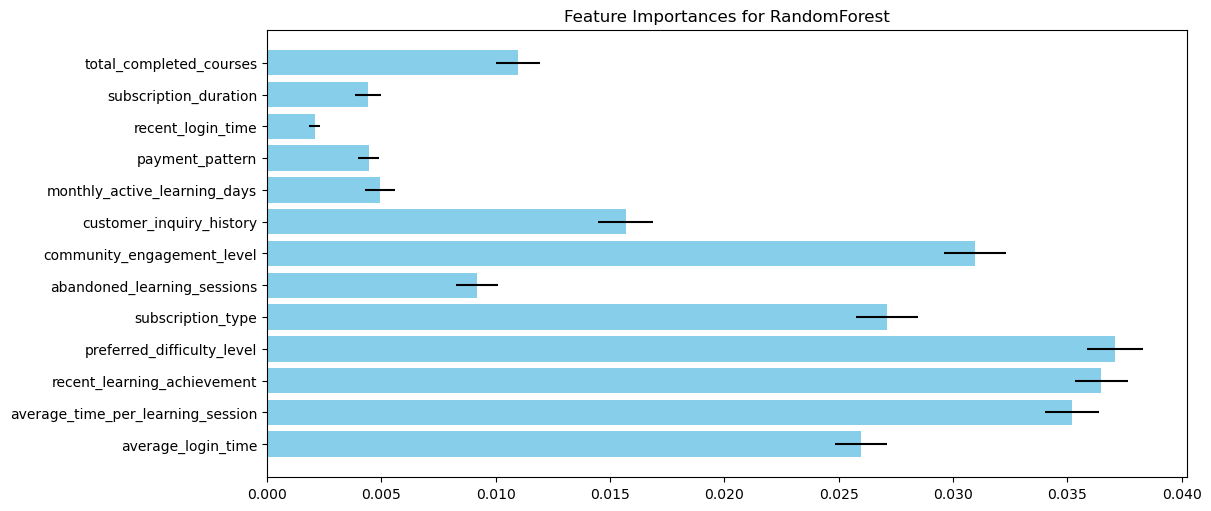

In [11]:
# 컬럼 순서대로 잘 불러오기!!
transformed_cols = list(num_cols) + [label_cols] + [ohe_cols]
left_behind_cols = X_train.columns.difference(transformed_cols)
feature_names = transformed_cols + list(left_behind_cols)

# feature importance
fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)
ax.barh(feature_names, pi.importances_mean, xerr=pi.importances_std, color='skyblue')
ax.set_title('Feature Importances for RandomForest')
plt.show()

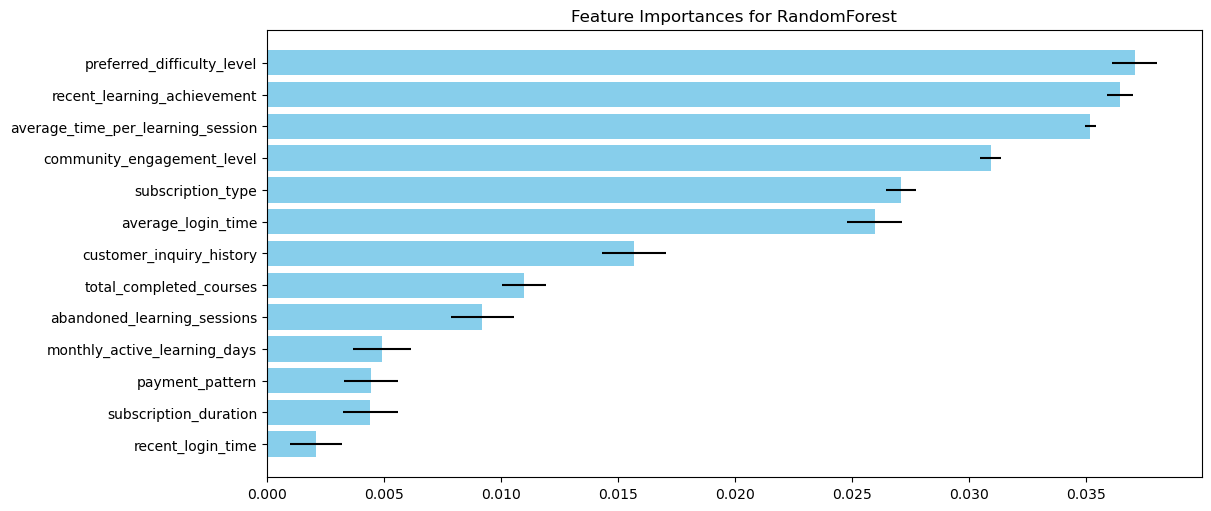

In [12]:
# feature importance 정렬
sorted_idx = pi.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)
ax.barh(np.array(feature_names)[sorted_idx], pi.importances_mean[sorted_idx],\
         xerr=pi.importances_std, color='skyblue')
ax.set_title('Feature Importances for RandomForest')
plt.show()

In [61]:
import mlflow 
from mlflow_utils import create_mlflow_experiment, get_mlflow_experiment
# results
# create_mlflow_experiment(experiment_name='test', artifact_location='test_artifacts', tags={'env': 'dev', 'version': '1.0'})
with mlflow.start_run(get_mlflow_experiment(experiment_name='test').experiment_id):
    pass
    # mlflow.log_metrics(results.keys, results.values)

MlflowException: Run '439615873627327450' not found

In [ ]:
import time
